In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier
from catboost import FeaturesData
from catboost import Pool, cv, train

%matplotlib inline

# Load Data

In [2]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')
print('Train:\t', train.shape)
print('Test: \t', test.shape)

Train:	 (307506, 172)
Test: 	 (48744, 171)


In [3]:
# define categorical features
cat_feature = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
               'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
               'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
               'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 
               'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
               'Binary_CREDIT_DAY_OVERDUE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 
               'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
               'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',  
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
               'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 
               'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
               'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
               'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
               'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
               'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',  'FLAG_DOCUMENT_20', 
               'FLAG_DOCUMENT_21']

dis_feature = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 
               'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'Total_BUREAU', 'Closed_BUREAU', 'Active_BUREAU', 'Sold_BUREAU', 
               'Bad_BUREAU', 'Count_AMT_CREDIT_MAX_OVERDUE', 'Credit_CREDIT_TYPE', 
               'Loan_CREDIT_TYPE', 'Count_POS_CASH', 'Completed_CASH_CONTRACT', 
               'Other_CASH_CONTRACT', 'Count_Credit_Card', 'Active_Credit_CONTRACT', 
               'Completed_Credit_CONTRACT', 'Other_Credit_CONTRACT', 'Count_installment', 
               'Count_prev', 'Count_prev_Cash_loan', 'Count_prev_Consumer_loan', 
               'Count_prev_Revolving_loan', 'Count_Y_prev_FLAG_LAST_APPL_PER_CONTRACT', 
               'Count_N_prev_FLAG_LAST_APPL_PER_CONTRACT', 'Count_1_prev_NFLAG_LAST_APPL_IN_DAY', 
               'Count_0_prev_NFLAG_LAST_APPL_IN_DAY', 'Count_Approved_prev_NAME_CONTRACT_STATUS', 
               'Count_Canceled_prev_NAME_CONTRACT_STATUS', 'Count_Refused_prev_NAME_CONTRACT_STATUS', 
               'Count_Unused_prev_NAME_CONTRACT_STATUS',  'Count_Cash_prev_NAME_PAYMENT_TYPE',
               'Count_XNA_prev_NAME_PAYMENT_TYPE', 'Count_Noncash_prev_NAME_PAYMENT_TYPE', 
               'Count_Unaccompanied_prev_NAME_TYPE_SUITE', 'Count_Accompanied_prev_NAME_TYPE_SUITE', 
               'Count_Other_NAME_TYPE_SUITE', 'Count_Repeater_prev_NAME_CLIENT_TYPE', 
               'Count_New_prev_NAME_CLIENT_TYPE', 'Count_Refreshed_prev_NAME_CLIENT_TYPE', 
               'Count_POS_prev_NAME_PORTFOLIO', 'Count_Cash_prev_NAME_PORTFOLIO', 
               'Count_Cards_prev_NAME_PORTFOLIO', 'Count_Other_prev_NAME_PORTFOLIO', 
               'Count_XNA_prev_NAME_PRODUCT_TYPE', 'Count_xsell_prev_NAME_PRODUCT_TYPE', 
               'Count_walkin_prev_NAME_PRODUCT_TYPE', 'Count_0_prev_NFLAG_INSURED_ON_APPROVAL', 
               'Count_1_prev_NFLAG_INSURED_ON_APPROVAL']

con_feature = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
               'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 
               'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'Sum_CASH_MONTH_BALANCE', 
               'Mean_CASH_MONTH_BALANCE', 'Median_CASH_MONTH_BALANCE', 'Sum_CASH_CNT_INSTALMENT', 
               'Mean_CASH_CNT_INSTALMENT', 'Median_CASH_CNT_INSTALMENT', 
               'Sum_CASH_CNT_INSTALMENT_FUTURE', 'Mean_CASH_CNT_INSTALMENT_FUTURE', 
               'Median_CASH_CNT_INSTALMENT_FUTURE', 'Active_CASH_CONTRACT', 
               'Sum_CASH_SK_DPD', 'Mean_CASH_SK_DPD', 'Median_CASH_SK_DPD', 'Sum_CASH_SK_DPD_DEF', 
               'Mean_CASH_SK_DPD_DEF', 'Median_CASH_SK_DPD_DEF', 'Sum_NUM_INSTALMENT_VERSION', 
               'Mean_NUM_INSTALMENT_VERSION', 'Median_NUM_INSTALMENT_VERSION', 
               'Sum_NUM_INSTALMENT_NUMBER', 'Mean_NUM_INSTALMENT_NUMBER', 
               'Median_NUM_INSTALMENT_NUMBER', 'Sum_DAYS_INSTALMENT', 'Mean_DAYS_INSTALMENT',
               'Median_DAYS_INSTALMENT', 'Sum_DAYS_ENTRY_PAYMENT', 'Mean_DAYS_ENTRY_PAYMENT', 
               'Median_DAYS_ENTRY_PAYMENT', 'Sum_AMT_INSTALMENT', 'Mean_AMT_INSTALMENT', 
               'Median_AMT_INSTALMENT', 'Sum_AMT_PAYMENT', 'Mean_AMT_PAYMENT', 'Median_AMT_PAYMENT',
               'Sum_prev_AMT_ANNUITY', 'Mean_prev_AMT_ANNUITY', 'Median_prev_AMT_ANNUITY', 
               'Sum_prev_AMT_APPLICATION', 'Mean_prev_AMT_APPLICATION', 'Median_prev_AMT_APPLICATION', 
               'Sum_prev_AMT_CREDIT', 'Mean_prev_AMT_CREDIT', 'Median_prev_AMT_CREDIT', 
               'Sum_prev_AMT_DOWN_PAYMENT', 'Sum_prev_AMT_GOODS_PRICE',  'Mean_prev_AMT_GOODS_PRICE', 
               'Median_prev_AMT_GOODS_PRICE', 'Sum_prev_RATE_DOWN_PAYMENT', 'Sum_prev_DAYS_DECISION', 
               'Mean_prev_DAYS_DECISION', 'Median_prev_DAYS_DECISION','Sum_prev_CNT_PAYMENT', 
               'Mean_prev_CNT_PAYMENT', 'Median_prev_CNT_PAYMENT']

features = cat_feature + dis_feature + con_feature

# define numerical and categorical features
print('Categorical:\t', len(cat_feature))
print('Discrete:\t', len(dis_feature))
print('Continuous:\t', len(con_feature))
print('Total:\t\t', len(features))

Categorical:	 49
Discrete:	 55
Continuous:	 66
Total:		 170


# Apply PCA 

In [4]:
# define features to be used
num_feature = dis_feature + con_feature
train_pca = train[num_feature]
test_pca = test[num_feature]

mean = np.mean(train_pca, axis=0)
std = np.std(train_pca, axis=0)

train_pca = (train_pca - mean) / std
test_pca = (test_pca - mean) / std

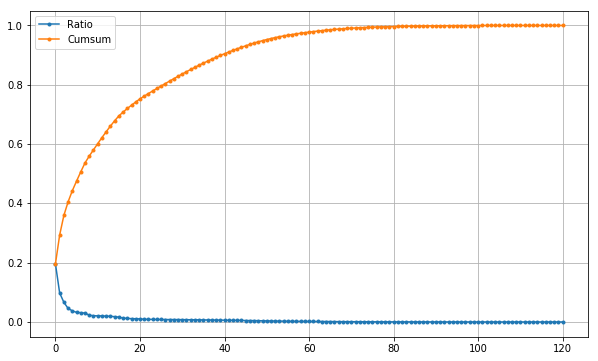

In [5]:
# build PCA model
pca = PCA(random_state=42)
pca = pca.fit(train_pca)

ratio = pca.explained_variance_ratio_

# visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ratio[:], '.-', label='Ratio')
ax.plot(np.cumsum(ratio)[:], '.-', label='Cumsum')
ax.legend()
ax.grid(True)
plt.show()

In [6]:
# Now let's keep the first 75 features
pca = PCA(n_components=75, random_state=42)
train_pca_feature = pca.fit_transform(train_pca)
test_pca_feature = pca.transform(test_pca)

In [7]:
# merge with categorical feature to get full feature
train_feature = np.concatenate((train[cat_feature], train_pca_feature), axis=1)
test_feature = np.concatenate((test[cat_feature], test_pca_feature), axis=1)

print('Train:\t', train_feature.shape)
print('Test: \t', test_feature.shape)

Train:	 (307506, 124)
Test: 	 (48744, 124)


# CatBoost Data Preparation

In [8]:
# create Pool object
train_pool = Pool(data=train_feature, label=train['TARGET'].values, 
                  cat_features=np.array(range(len(cat_feature))))

test_pool = Pool(data=test[features], cat_features=np.array(range(len(cat_feature))))

In [9]:
train_labels = train['TARGET'].values
print('Negative class:\t', sum(train_labels == 0))
print('Positive class:\t', sum(train_labels == 1))
print('Neg / Pos:\t', sum(train_labels == 0) / sum(train_labels == 1))

Negative class:	 282682
Positive class:	 24824
Neg / Pos:	 11.387447631324525


In [10]:
# # encoding categorical data into numerical format
# label_encoders = []
# for name in cat_feature:
#     encoder = LabelEncoder()
#     train[name] = encoder.fit_transform(train[name])
#     test[name] = encoder.transform(test[name])
#     label_encoders.append(encoder)

In [11]:
# # prepare the dataset
# train_data = FeaturesData(
#     num_feature_data=np.array(train[dis_feature + con_feature].values, dtype=np.float32), 
#     cat_feature_data=np.array(train[cat_feature].values, dtype=object), 
#     num_feature_names=dis_feature + con_feature,
#     cat_feature_names=cat_feature)

# train_labels = train['TARGET'].values

# test_data = FeaturesData(
#     num_feature_data=np.array(test[dis_feature + con_feature].values, dtype=np.float32), 
#     cat_feature_data=np.array(test[cat_feature].values, dtype=object), 
#     num_feature_names=dis_feature + con_feature,
#     cat_feature_names=cat_feature)

# CatBoost Cross Validation

In [12]:
# # define parameters
# params = {'loss_function': 'Logloss', 
#           'custom_metric': 'AUC', 
#           'eval_metric': 'AUC',
#           'learning_rate': 0.03, 
#           'random_seed': 42, 
#           'l2_leaf_reg': None,
#           'bootstrap_type': 'Bayesian', 
#           'bagging_temperature': 1, 
#           'depth': 6,  
#           'has_time': False, 
#           'class_weights': [1, 11]}

# scores = cv(pool=train_pool, params=params, iterations=10, fold_count=5,
#             seed=42, shuffle=True, logging_level=None, stratified=True,
#             as_pandas=False, metric_period=50, verbose=None, plot=False,
#             early_stopping_rounds=10)

In [13]:
# # get results
# train_auc_mean = np.array(scores['train-AUC-mean'])
# train_auc_std = np.array(scores['train-AUC-std'])
# test_auc_mean = np.array(scores['test-AUC-mean'])
# test_auc_std = np.array(scores['test-AUC-std'])

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(range(1, len(train_auc_mean)+1), train_auc_mean, label='Train AUC')
# ax.plot(range(1, len(test_auc_mean)+1), test_auc_mean, label='Test AUC')
# ax.fill_between(range(1, len(train_auc_mean)+1), train_auc_mean+train_auc_std, 
#                 train_auc_mean-train_auc_std, alpha=0.1, label='Train Error')
# ax.fill_between(range(1, len(test_auc_mean)+1), test_auc_mean+test_auc_std, 
#                 test_auc_mean-test_auc_std, alpha=0.1, label='Test Error')
# ax.legend(fontsize=12)
# plt.show()

# CatBoost Random Search

In [14]:
# define parameter space to explore
learning_rate_list = [0.03, 0.05, 0.08, 0.1]
depth_list = [4, 5, 6, 7, 8, 9, 10]
l2_leaf_reg_list = [1, 3, 5, 7, 9]
random_strength_list = [0.1, 0.5, 1, 2]
bagging_temperature_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

learning_rate_values = []
depth_values = []
l2_leaf_reg_values = []
random_strength_values = []
bagging_temperature_values = []

best_iterations_values = []
train_mean_auc_values = []
train_auc_std_values = []
test_mean_auc_values = []
test_auc_std_values = []

In [15]:
# Random search with Cross validation
s = '|{0:>13s} |{1:>5s} |{2:>11s} |{3:>15s} |{4:>19s} |{5:>10s} |{6:>9s} |{7:>9s} |'
print(s.format('learning_rate', 'depth', 'l2_leaf_reg', 'random_strength', 
               'bagging_temperature', 'iterations', 'train_AUC', 'test_AUC'))
print('-' * 108)

# perform random search for given number n
n = 30
np.random.seed(42)
visited = set()
for i in range(n):
    while True:
        learning_rate = np.random.choice(learning_rate_list)
        depth = np.random.choice(depth_list)
        l2_leaf_reg = np.random.choice(l2_leaf_reg_list)
        random_strength = np.random.choice(random_strength_list)
        bagging_temperature = np.random.choice(bagging_temperature_list)
        
        tuples = (learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature)
        if tuples not in visited:
            visited.add(tuples)
            break
            
    # define parameters
    params = {'loss_function': 'Logloss', 
              'custom_metric': 'AUC', 
              'eval_metric': 'AUC',
              'learning_rate': learning_rate, 
              'depth': depth, 
              'l2_leaf_reg': l2_leaf_reg,
              'random_strength': random_strength, 
              'bagging_temperature': bagging_temperature, 
              'random_seed': 42, 
              'bootstrap_type': 'Bayesian', 
              'has_time': False, 
              'class_weights': [1, 11]}

    scores = cv(pool=train_pool, params=params, iterations=1000, fold_count=5,
                seed=42, shuffle=True, logging_level='Silent', stratified=True,
                as_pandas=False, metric_period=1, early_stopping_rounds=20)
    
    # get result
    learning_rate_values.append(learning_rate)
    depth_values.append(depth)
    l2_leaf_reg_values.append(l2_leaf_reg)
    random_strength_values.append(random_strength)
    bagging_temperature_values.append(bagging_temperature)
    
    best_idx = np.argmax(scores['test-AUC-mean'])
    best_iterations = best_idx + 1
    train_mean_auc = scores['train-AUC-mean'][best_idx]
    train_auc_std = scores['train-AUC-std'][best_idx]
    test_mean_auc = scores['test-AUC-mean'][best_idx]
    test_auc_std = scores['test-AUC-std'][best_idx]
    
    best_iterations_values.append(best_iterations)
    train_mean_auc_values.append(train_mean_auc)
    train_auc_std_values.append(train_auc_std)
    test_mean_auc_values.append(test_mean_auc)
    test_auc_std_values.append(test_auc_std)
    
    # output the resuts
    ss = '|{0:>13.4f} |{1:>5d} |{2:>11d} |{3:>15.4f} |{4:>19.4f} |{5:>10d} |{6:>9.4f} |{7:>9.4f} |'
    print(ss.format(learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature, 
                    best_iterations, train_mean_auc, test_mean_auc))
    
# get the best parameters
idx = np.argmax(test_mean_auc_values)
print('-' * 108)
print(ss.format(learning_rate_values[idx], depth_values[idx], l2_leaf_reg_values[idx], 
                random_strength_values[idx], bagging_temperature_values[idx], 
                best_iterations_values[idx], train_mean_auc_values[idx], 
                test_mean_auc_values[idx]))

|learning_rate |depth |l2_leaf_reg |random_strength |bagging_temperature |iterations |train_AUC | test_AUC |
------------------------------------------------------------------------------------------------------------
|       0.0800 |    7 |          9 |         1.0000 |             0.4000 |       326 |   0.8311 |   0.7559 |
|       0.1000 |    8 |          9 |         1.0000 |             0.2000 |       166 |   0.8362 |   0.7529 |
|       0.0800 |   10 |          5 |         1.0000 |             0.8000 |       117 |   0.8761 |   0.7448 |
|       0.1000 |    6 |          9 |         0.5000 |             0.6000 |       355 |   0.8156 |   0.7563 |
|       0.0500 |    9 |          3 |         2.0000 |             0.6000 |       297 |   0.8718 |   0.7507 |
|       0.0300 |    4 |          7 |         0.5000 |             1.0000 |       999 |   0.7722 |   0.7549 |
|       0.0300 |    7 |          1 |         0.1000 |             0.4000 |       631 |   0.8183 |   0.7551 |
|       0.0800 |   

# CatBoost Boosting

In [16]:
# build CatBoost classifier
model = CatBoostClassifier(loss_function='Logloss', custom_metric='AUC', eval_metric='AUC',
                           learning_rate=0.05, depth=5, l2_leaf_reg=7, random_strength=0.5, 
                           bagging_temperature=1.0, iterations=998, random_seed=42, 
                           class_weights=[1, 11], bootstrap_type='Bayesian', subsample=None,
                           use_best_model=None, ignored_features=None, one_hot_max_size=None, 
                           has_time=False, rsm=None, nan_mode=None, leaf_estimation_iterations=None, 
                           leaf_estimation_method=None, boosting_type=None, allow_const_label=None)

model.fit(X=train_pool, eval_set=None, logging_level='Verbose', plot=False, 
          column_description=None, metric_period=50, early_stopping_rounds=None)

catboost_test_pred = model.predict_proba(data=test_pool)[:, 1]

0:	total: 187ms	remaining: 3m 6s
50:	total: 8.31s	remaining: 2m 34s
100:	total: 16.3s	remaining: 2m 24s
150:	total: 24.4s	remaining: 2m 16s
200:	total: 32.3s	remaining: 2m 8s
250:	total: 40.3s	remaining: 2m
300:	total: 48.3s	remaining: 1m 51s
350:	total: 56.3s	remaining: 1m 43s
400:	total: 1m 4s	remaining: 1m 35s
450:	total: 1m 12s	remaining: 1m 27s
500:	total: 1m 20s	remaining: 1m 19s
550:	total: 1m 28s	remaining: 1m 11s
600:	total: 1m 36s	remaining: 1m 3s
650:	total: 1m 44s	remaining: 55.5s
700:	total: 1m 52s	remaining: 47.5s
750:	total: 2m	remaining: 39.5s
800:	total: 2m 8s	remaining: 31.5s
850:	total: 2m 16s	remaining: 23.5s
900:	total: 2m 24s	remaining: 15.5s
950:	total: 2m 32s	remaining: 7.52s
997:	total: 2m 39s	remaining: 0us


In [17]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = catboost_test_pred

catboost_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                            columns=['SK_ID_CURR', 'TARGET'])
catboost_csv.to_csv('./result/pca_feature_boosting_catboost_balanced.csv', index=False)